<a href="https://colab.research.google.com/github/data-science-and-machine-learning/human-activity-recognition/blob/master/HAR_LSTM_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Importing Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import  seaborn as sns

In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [0]:
# credits to appliedaicourse.com
# precision and recall:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)

    B =(C/C.sum(axis=0))
    
    labels = list(ACTIVITIES.values())#[1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

### Data

In [0]:
# Data directory
DRIVEDIR= 'drive/My Drive/Colab Notebooks/HumanActivityRecognition/HAR/'
DATADIR = 'UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(DRIVEDIR+ filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(DRIVEDIR+ filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [0]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [0]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [50]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [52]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

W0820 02:54:59.862100 140588124379008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0820 02:54:59.871063 140588124379008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0820 02:54:59.880997 140588124379008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0820 02:55:00.084766 140588124379008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0820 02:55:00.094695 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

W0819 17:03:03.588121 140708500006784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0819 17:03:03.617892 140708500006784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [0]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

W0819 17:03:03.906327 140708500006784 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 106s 14ms/step - loss: 1.3145 - acc: 0.4391 - val_loss: 1.1425 - val_acc: 0.4706
Epoch 2/30
7352/7352 [==============================] - 100s 14ms/step - loss: 0.9653 - acc: 0.5835 - val_loss: 0.9276 - val_acc: 0.5938
Epoch 3/30
7352/7352 [==============================] - 100s 14ms/step - loss: 0.8150 - acc: 0.6451 - val_loss: 0.8213 - val_acc: 0.6003
Epoch 4/30
7352/7352 [==============================] - 102s 14ms/step - loss: 0.7518 - acc: 0.6473 - val_loss: 0.7765 - val_acc: 0.6162
Epoch 5/30
7352/7352 [==============================] - 100s 14ms/step - loss: 0.7287 - acc: 0.6470 - val_loss: 0.8255 - val_acc: 0.6105
Epoch 6/30
7352/7352 [==============================] - 99s 13ms/step - loss: 0.6780 - acc: 0.6575 - val_loss: 0.7989 - val_acc: 0.5962
Epoch 7/30
7352/7352 [==============================] - 100s 14ms/step - loss: 0.6556 - acc: 0.6711 - val_loss: 0.6918 - val_acc: 0

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 511        0  ...                   0                 0
SITTING                  4      382  ...                   1                 0
STANDING                 0       93  ...                   0                 0
WALKING                  0        0  ...                  27                 5
WALKING_DOWNSTAIRS       0        0  ...                 419                 1
WALKING_UPSTAIRS         0        1  ...                  39               430

[6 rows x 6 columns]


In [0]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 7s 3ms/step


In [0]:
score

[0.4354593948134317, 0.8971835765184933]

- With a simple 2 layer architecture we got 90.09% accuracy and a loss of 0.30
- We can further imporve the performace with Hyperparameter tuning

### Hyperparameter Tuning

In [0]:
def modelgen(n_hidden, dropout_rate):
  model = Sequential()
  # Configuring the parameters
  model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
  # Adding a dropout layer
  model.add(Dropout(dropout_rate))
  # Adding a dense output layer with sigmoid activation
  model.add(Dense(n_classes, activation='sigmoid'))
  
  model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
  return model

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, ShuffleSplit

model = KerasClassifier(build_fn=modelgen, epochs=20, verbose=0)

param_grid = dict(n_hidden= [32, 64],\
                  dropout_rate= [0.25, 0.50, 0.75])

grid = GridSearchCV(estimator= model, param_grid= param_grid, cv= 2, return_train_score= True, verbose= 10)
grid_result= grid.fit(X_train, Y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] dropout_rate=0.25, n_hidden=32 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
W0820 02:59:38.418785 140588124379008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0820 02:59:38.438404 140588124379008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0820 02:59:38.567371 140588124379008 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[CV]  dropout_rate=0.25, n_hidden=32, score=(train=0.892, test=0.795), total= 6.4min
[CV] dropout_rate=0.25, n_hidden=32 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.5min remaining:    0.0s


[CV]  dropout_rate=0.25, n_hidden=32, score=(train=0.891, test=0.856), total= 6.4min
[CV] dropout_rate=0.25, n_hidden=64 ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 13.0min remaining:    0.0s


[CV]  dropout_rate=0.25, n_hidden=64, score=(train=0.964, test=0.865), total= 6.4min
[CV] dropout_rate=0.25, n_hidden=64 ..................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 19.4min remaining:    0.0s


[CV]  dropout_rate=0.25, n_hidden=64, score=(train=0.925, test=0.906), total= 6.4min
[CV] dropout_rate=0.5, n_hidden=32 ...................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 25.9min remaining:    0.0s


[CV]  dropout_rate=0.5, n_hidden=32, score=(train=0.675, test=0.632), total= 6.3min
[CV] dropout_rate=0.5, n_hidden=32 ...................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 32.4min remaining:    0.0s


[CV]  dropout_rate=0.5, n_hidden=32, score=(train=0.760, test=0.753), total= 6.4min
[CV] dropout_rate=0.5, n_hidden=64 ...................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 38.9min remaining:    0.0s


[CV]  dropout_rate=0.5, n_hidden=64, score=(train=0.923, test=0.845), total= 6.3min
[CV] dropout_rate=0.5, n_hidden=64 ...................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 45.3min remaining:    0.0s


[CV]  dropout_rate=0.5, n_hidden=64, score=(train=0.881, test=0.839), total= 6.4min
[CV] dropout_rate=0.75, n_hidden=32 ..................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 51.8min remaining:    0.0s
W0820 03:51:26.572323 140588124379008 nn_ops.py:4224] Large dropout rate: 0.75 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


[CV]  dropout_rate=0.75, n_hidden=32, score=(train=0.647, test=0.589), total= 6.4min
[CV] dropout_rate=0.75, n_hidden=32 ..................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 58.3min remaining:    0.0s
W0820 03:57:57.476649 140588124379008 nn_ops.py:4224] Large dropout rate: 0.75 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


[CV]  dropout_rate=0.75, n_hidden=32, score=(train=0.632, test=0.654), total= 6.4min
[CV] dropout_rate=0.75, n_hidden=64 ..................................


W0820 04:04:28.257844 140588124379008 nn_ops.py:4224] Large dropout rate: 0.75 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


[CV]  dropout_rate=0.75, n_hidden=64, score=(train=0.820, test=0.735), total= 6.4min
[CV] dropout_rate=0.75, n_hidden=64 ..................................


W0820 04:10:57.610683 140588124379008 nn_ops.py:4224] Large dropout rate: 0.75 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


[CV]  dropout_rate=0.75, n_hidden=64, score=(train=0.715, test=0.704), total= 6.4min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 77.8min finished


In [0]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Best estimator: ", grid_result.best_estimator_)

means_test = grid_result.cv_results_['mean_test_score']
means_train = grid_result.cv_results_['mean_train_score']
stds_test = grid_result.cv_results_['std_test_score']
stds_train = grid_result.cv_results_['std_train_score']
params = grid_result.cv_results_['params']

for mean, mean_train, stdev, param in zip(means_test, means_train, stds_test, params):
    print("%f %f (%f) with: %r" % (mean, mean_train, stdev, param))

Best: 0.885201 using {'dropout_rate': 0.25, 'n_hidden': 64}
Best estimator:  <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fdce04566d8>
0.825626 0.891458 (0.030196) with: {'dropout_rate': 0.25, 'n_hidden': 32}
0.885201 0.944233 (0.020403) with: {'dropout_rate': 0.25, 'n_hidden': 64}
0.692737 0.717764 (0.060528) with: {'dropout_rate': 0.5, 'n_hidden': 32}
0.841812 0.901795 (0.002856) with: {'dropout_rate': 0.5, 'n_hidden': 64}
0.621736 0.639418 (0.032236) with: {'dropout_rate': 0.75, 'n_hidden': 32}
0.719804 0.767682 (0.015506) with: {'dropout_rate': 0.75, 'n_hidden': 64}


In [0]:
# best model 
best_model= modelgen(64, 0.25)
history= best_model.fit(X_train, Y_train, nb_epoch=30, batch_size=64, validation_data=(X_test, Y_test))
# Final evaluation of the model
scores = best_model.evaluate(X_test, Y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 25s 3ms/step - loss: 1.3357 - acc: 0.4017 - val_loss: 1.2364 - val_acc: 0.4499
Epoch 2/30
7352/7352 [==============================] - 22s 3ms/step - loss: 1.1287 - acc: 0.4827 - val_loss: 1.1458 - val_acc: 0.4832
Epoch 3/30
7352/7352 [==============================] - 22s 3ms/step - loss: 1.1017 - acc: 0.5140 - val_loss: 1.0085 - val_acc: 0.5758
Epoch 4/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.8886 - acc: 0.6031 - val_loss: 0.8575 - val_acc: 0.5843
Epoch 5/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.7373 - acc: 0.6695 - val_loss: 0.7367 - val_acc: 0.6987
Epoch 6/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.6223 - acc: 0.7312 - val_loss: 0.6895 - val_acc: 0.7618
Epoch 7/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.5296 - acc: 0.7826 - val_loss: 0.5852 - val_acc: 0.7764
Epoch 8

In [0]:
scores

[0.21523868973672827, 0.9205972175093315]

Test loss: 0.21523868973672827
Test accuracy: 0.9205972175093315
[0.21523868973672827, 0.9205972175093315]


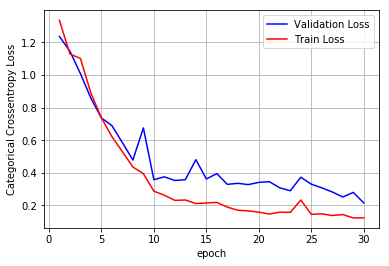

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def plt_dynamic(x, vy, ty, colors=['b']):
 fig,ax = plt.subplots(1,1)
 ax.set_xlabel('epoch')
 ax.set_ylabel('Categorical Crossentropy Loss')
 ax.plot(x, vy, 'b', label="Validation Loss")
 ax.plot(x, ty, 'r', label="Train Loss")
 plt.legend()
 plt.grid()
 fig.canvas.draw()


print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print(scores)
x = list(range(1,31))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)

Number of misclassified points  7.940278249066848
-------------------------------------------------- Confusion matrix --------------------------------------------------


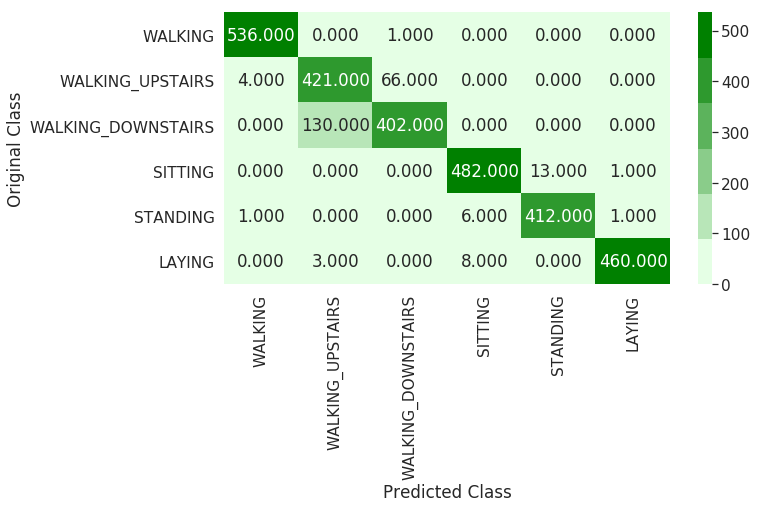

-------------------------------------------------- Precision matrix --------------------------------------------------


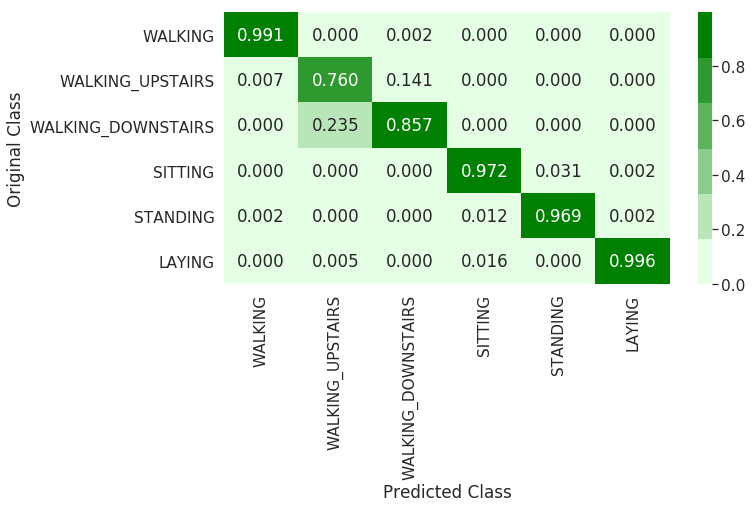

Sum of columns in precision matrix Pred
LAYING                1.0
SITTING               1.0
STANDING              1.0
WALKING               1.0
WALKING_DOWNSTAIRS    1.0
WALKING_UPSTAIRS      1.0
dtype: float64
-------------------------------------------------- Recall matrix --------------------------------------------------


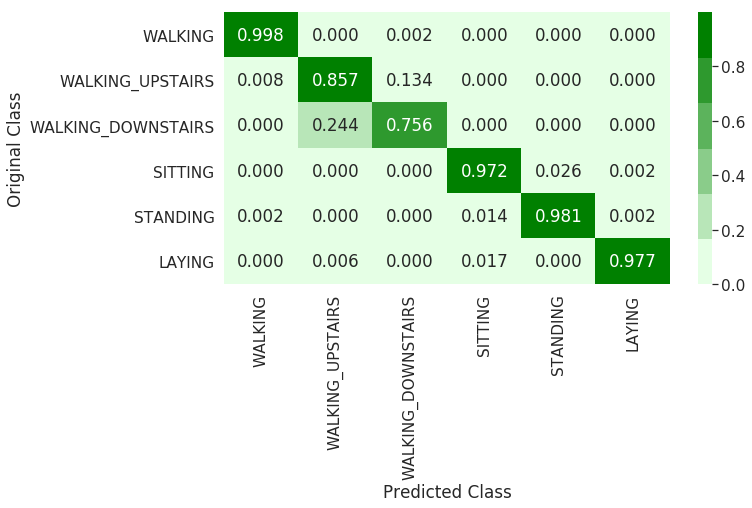

Sum of rows in precision matrix True
LAYING                1.0
SITTING               1.0
STANDING              1.0
WALKING               1.0
WALKING_DOWNSTAIRS    1.0
WALKING_UPSTAIRS      1.0
dtype: float64


In [0]:
plot_confusion_matrix(Y_test, best_model.predict(X_test))

### Adding 1 more LSTM layer

In [0]:

n_hidden= 32
batch_size = 32

# Initiliazing the sequential model
newmodel = Sequential()
# Configuring the parameters
newmodel.add(LSTM(n_hidden, return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
newmodel.add(Dropout(0.50))
# Configuring the parameters
newmodel.add(LSTM(n_hidden))
# Adding a dropout layer
newmodel.add(Dropout(0.50))
# Adding a dense output layer with sigmoid activation
newmodel.add(Dense(n_classes, activation='sigmoid'))
newmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 128, 32)           5376      
_________________________________________________________________
dropout_33 (Dropout)         (None, 128, 32)           0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_34 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 6)                 198       
Total params: 13,894
Trainable params: 13,894
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
newmodel.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
# Training the model
history= newmodel.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 95s 13ms/step - loss: 1.2989 - acc: 0.4656 - val_loss: 1.0743 - val_acc: 0.5490
Epoch 2/30
7352/7352 [==============================] - 90s 12ms/step - loss: 0.8991 - acc: 0.6079 - val_loss: 0.7783 - val_acc: 0.5935
Epoch 3/30
7352/7352 [==============================] - 89s 12ms/step - loss: 0.7549 - acc: 0.6556 - val_loss: 0.8290 - val_acc: 0.5908
Epoch 4/30
7352/7352 [==============================] - 90s 12ms/step - loss: 0.6999 - acc: 0.6854 - val_loss: 0.6701 - val_acc: 0.6841
Epoch 5/30
7352/7352 [==============================] - 89s 12ms/step - loss: 0.6305 - acc: 0.7213 - val_loss: 0.6279 - val_acc: 0.7251
Epoch 6/30
7352/7352 [==============================] - 89s 12ms/step - loss: 0.5472 - acc: 0.7782 - val_loss: 0.4646 - val_acc: 0.7625
Epoch 7/30
7352/7352 [==============================] - 89s 12ms/step - loss: 0.4656 - acc: 0.8220 - val_loss: 0.5769 - val_acc: 0.7974


AttributeError: ignored

Test loss: 0.40216667606969797
Test accuracy: 0.9114353579911775
[0.40216667606969797, 0.9114353579911775]


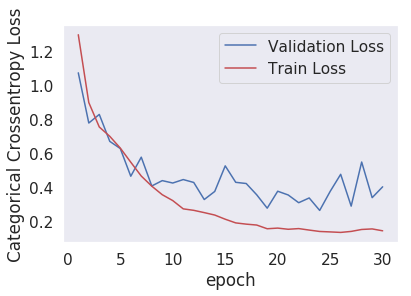

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def plt_dynamic(x, vy, ty, colors=['b']):
 fig,ax = plt.subplots(1,1)
 ax.set_xlabel('epoch')
 ax.set_ylabel('Categorical Crossentropy Loss')
 ax.plot(x, vy, 'b', label="Validation Loss")
 ax.plot(x, ty, 'r', label="Train Loss")
 plt.legend()
 plt.grid()
 fig.canvas.draw()

scores = newmodel.evaluate(X_test, Y_test, verbose=0)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print(scores)
x = list(range(1,31))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)

Number of misclassified points  8.856464200882252
-------------------------------------------------- Confusion matrix --------------------------------------------------


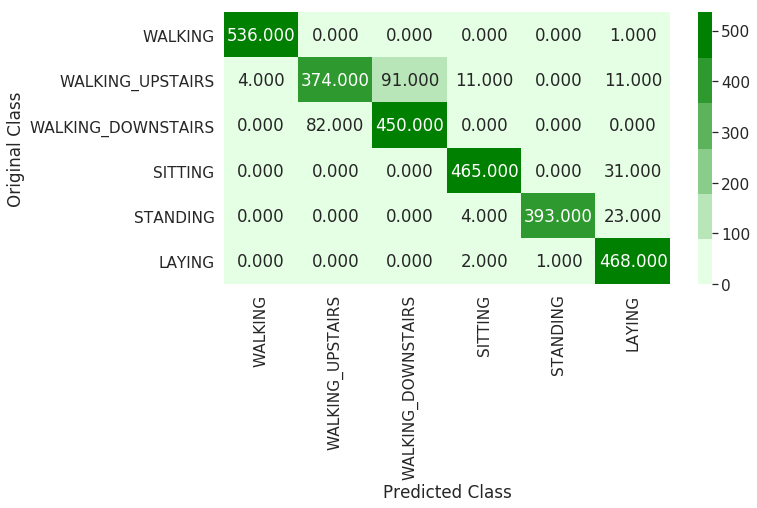

-------------------------------------------------- Precision matrix --------------------------------------------------


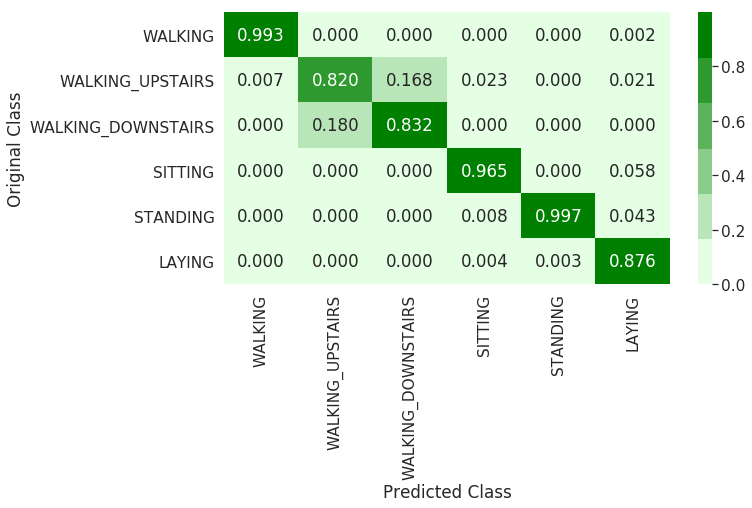

Sum of columns in precision matrix Pred
LAYING                1.0
SITTING               1.0
STANDING              1.0
WALKING               1.0
WALKING_DOWNSTAIRS    1.0
WALKING_UPSTAIRS      1.0
dtype: float64
-------------------------------------------------- Recall matrix --------------------------------------------------


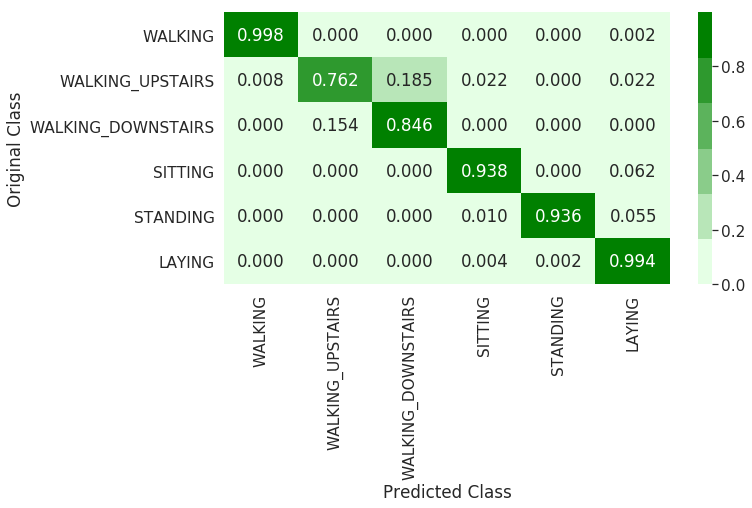

Sum of rows in precision matrix True
LAYING                1.0
SITTING               1.0
STANDING              1.0
WALKING               1.0
WALKING_DOWNSTAIRS    1.0
WALKING_UPSTAIRS      1.0
dtype: float64


In [0]:
plot_confusion_matrix(Y_test, newmodel.predict(X_test))

Observation:

In [0]:
print(' Precision for walking upstairs is improved from 76% to 82%')

 Precision for walking upstairs is improved from 76% to 82%


In [0]:
from prettytable import PrettyTable
x= PrettyTable(['Model', 'Loss', 'Accuracy', 'Observation'])
x.add_row(['Single LSTM layer', '0.215', '0.920', 'Simple LSTM model with hyperparameter tuning'])
x.add_row(['Double LSTM layers', '0.402', '0.911', 'Double layers of LSTM with dropouts'])
x.align= 'l'
print(x)
print('Model can improve further applying hyper parameter tuning to 2 layer LSTM')

+--------------------+-------+----------+----------------------------------------------+
| Model              | Loss  | Accuracy | Observation                                  |
+--------------------+-------+----------+----------------------------------------------+
| Single LSTM layer  | 0.215 | 0.920    | Simple LSTM model with hyperparameter tuning |
| Double LSTM layers | 0.402 | 0.911    | Double layers of LSTM with dropouts          |
+--------------------+-------+----------+----------------------------------------------+
Model can improve further applying hyper parameter tuning to 2 layer LSTM


### After Submission task

In [0]:
n_hidden= 32
batch_size = 32

# Initiliazing the sequential model
newmodel = Sequential()
# Configuring the parameters
newmodel.add(LSTM(n_hidden, return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
newmodel.add(Dropout(0.75))
# Configuring the parameters
newmodel.add(LSTM(n_hidden))
# Adding a dropout layer
newmodel.add(Dropout(0.75))
# Adding a dense output layer with sigmoid activation
newmodel.add(Dense(n_classes, activation='sigmoid'))
newmodel.summary()

### Trying CNN model with the data

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 42s 6ms/step - loss: 0.9269 - acc: 0.6574 - val_loss: 0.4757 - val_acc: 0.8368
Epoch 2/30
7352/7352 [==============================] - 29s 4ms/step - loss: 0.3662 - acc: 0.8777 - val_loss: 0.6454 - val_acc: 0.7978
Epoch 3/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.2327 - acc: 0.9188 - val_loss: 0.5037 - val_acc: 0.8721
Epoch 4/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.1601 - acc: 0.9406 - val_loss: 0.5232 - val_acc: 0.8799
Epoch 5/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.1329 - acc: 0.9475 - val_loss: 0.5071 - val_acc: 0.8996
Epoch 6/30
7352/7352 [==============================] - 29s 4ms/step - loss: 0.1457 - acc: 0.9433 - val_loss: 0.5095 - val_acc: 0.9009
Epoch 7/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.1757 - acc: 0.9384 - val_loss: 0.5014 - val_acc: 0.8958
Epoch 8

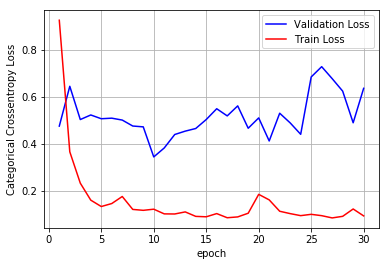

In [87]:
from keras.layers import Conv1D, BatchNormalization, Dropout, MaxPool1D, Flatten
import keras


n_epocs= 30
def modelgen(filters):
  cnnmodel= Sequential()
  cnnmodel.add(Conv1D(filters=filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(MaxPool1D(pool_size=2))

  cnnmodel.add(Conv1D(filters=filters*2, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(MaxPool1D(pool_size=2))

  cnnmodel.add(LSTM(filters*2, return_sequences=True, activation='relu', kernel_initializer='he_normal'))

  cnnmodel.add(LSTM(filters, return_sequences=True, activation='relu', kernel_initializer='he_normal'))

  cnnmodel.add(Flatten())

  cnnmodel.add(Dense(1024, activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(Dropout(0.80))
  
  cnnmodel.add(Dense(1024, activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(Dropout(0.80))

  cnnmodel.add(Dense(6, activation='softmax'))
  cnnmodel.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])#RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

  return cnnmodel


m= modelgen(64)

history= m.fit(X_train,
          Y_train,
          batch_size=64,
          validation_data=(X_test, Y_test),
          epochs=n_epocs)
m.summary()


import matplotlib.pyplot as plt
%matplotlib inline

def plt_dynamic(x, vy, ty, colors=['b']):
 fig,ax = plt.subplots(1,1)
 ax.set_xlabel('epoch')
 ax.set_ylabel('Categorical Crossentropy Loss')
 ax.plot(x, vy, 'b', label="Validation Loss")
 ax.plot(x, ty, 'r', label="Train Loss")
 plt.legend()
 plt.grid()
 fig.canvas.draw()

scores = m.evaluate(X_test, Y_test, verbose=0)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print(scores)
x = list(range(1,n_epocs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)





### 3 conv layers with reduced pooling and LSTM


Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 25s 3ms/step - loss: 1.5878 - acc: 0.3279 - val_loss: 1.2133 - val_acc: 0.5185
Epoch 2/30
7352/7352 [==============================] - 2s 294us/step - loss: 0.8321 - acc: 0.5775 - val_loss: 0.5308 - val_acc: 0.6712
Epoch 3/30
7352/7352 [==============================] - 2s 300us/step - loss: 0.5078 - acc: 0.7133 - val_loss: 0.4022 - val_acc: 0.7974
Epoch 4/30
7352/7352 [==============================] - 2s 298us/step - loss: 0.2864 - acc: 0.8852 - val_loss: 0.3499 - val_acc: 0.8758
Epoch 5/30
7352/7352 [==============================] - 2s 298us/step - loss: 0.1743 - acc: 0.9346 - val_loss: 0.2978 - val_acc: 0.9141
Epoch 6/30
7352/7352 [==============================] - 2s 295us/step - loss: 0.1574 - acc: 0.9412 - val_loss: 0.2729 - val_acc: 0.9141
Epoch 7/30
7352/7352 [==============================] - 2s 295us/step - loss: 0.1879 - acc: 0.9321 - val_loss: 0.2030 - val_acc: 0.9250
E

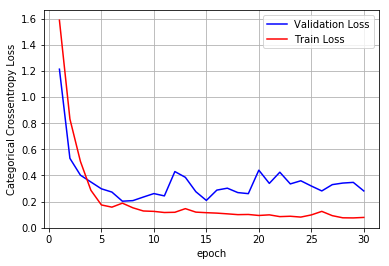

In [119]:
from keras.layers import Conv1D, BatchNormalization, Dropout, MaxPool1D, Flatten
import keras


n_epocs= 30
def modelgen(filters):
  cnnmodel= Sequential()
  cnnmodel.add((Conv1D(filters=filters, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal')))
  cnnmodel.add((Conv1D(filters=filters, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal')))
  cnnmodel.add((MaxPool1D(pool_size=7))) #3

  cnnmodel.add(Conv1D(filters=filters*2, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(Conv1D(filters=filters*2, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(MaxPool1D(pool_size=5))

  cnnmodel.add(Conv1D(filters=filters*2, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(Conv1D(filters=filters*2, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(MaxPool1D(pool_size=3))


  cnnmodel.add(LSTM(filters*2, return_sequences=True, activation='relu', kernel_initializer='he_normal'))

  cnnmodel.add(LSTM(filters*1, return_sequences=True, activation='relu', kernel_initializer='he_normal'))
  
  cnnmodel.add(Flatten())

  cnnmodel.add(Dense(filters**2, activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(Dropout(0.90))
  
  cnnmodel.add(Dense(filters**2, activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(Dropout(0.90))

  cnnmodel.add(Dense(6, activation='softmax'))
  cnnmodel.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])#RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

  return cnnmodel

m= modelgen(32)

history= m.fit(X_train, Y_train, batch_size=128, validation_data=(X_test, Y_test), epochs=n_epocs)
m.summary()


import matplotlib.pyplot as plt
%matplotlib inline

def plt_dynamic(x, vy, ty, colors=['b']):
 fig,ax = plt.subplots(1,1)
 ax.set_xlabel('epoch')
 ax.set_ylabel('Categorical Crossentropy Loss')
 ax.plot(x, vy, 'b', label="Validation Loss")
 ax.plot(x, ty, 'r', label="Train Loss")
 plt.legend()
 plt.grid()
 fig.canvas.draw()

scores = m.evaluate(X_test, Y_test, verbose=0)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print(scores)
x = list(range(1,n_epocs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)


Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 24s 3ms/step - loss: 1.4541 - acc: 0.3715 - val_loss: 1.0821 - val_acc: 0.5321
Epoch 2/30
7352/7352 [==============================] - 2s 290us/step - loss: 0.9068 - acc: 0.5399 - val_loss: 0.6762 - val_acc: 0.6590
Epoch 3/30
7352/7352 [==============================] - 2s 292us/step - loss: 0.5073 - acc: 0.7354 - val_loss: 0.3613 - val_acc: 0.8517
Epoch 4/30
7352/7352 [==============================] - 2s 291us/step - loss: 0.2400 - acc: 0.9138 - val_loss: 0.3317 - val_acc: 0.8806
Epoch 5/30
7352/7352 [==============================] - 2s 292us/step - loss: 0.1957 - acc: 0.9271 - val_loss: 0.2476 - val_acc: 0.9145
Epoch 6/30
7352/7352 [==============================] - 2s 291us/step - loss: 0.1514 - acc: 0.9429 - val_loss: 0.3086 - val_acc: 0.9036
Epoch 7/30
7352/7352 [==============================] - 2s 290us/step - loss: 0.1540 - acc: 0.9421 - val_loss: 0.3381 - val_acc: 0.9060
E

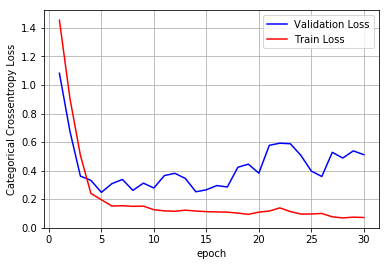

In [117]:
from keras.layers import Conv1D, BatchNormalization, Dropout, MaxPool1D, Flatten
import keras


n_epocs= 30
def modelgen(filters):
  cnnmodel= Sequential()
  cnnmodel.add((Conv1D(filters=filters, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal')))
  cnnmodel.add((Conv1D(filters=filters, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal')))
  cnnmodel.add((MaxPool1D(pool_size=7))) #3

  cnnmodel.add(Conv1D(filters=filters*2, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(Conv1D(filters=filters*2, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(MaxPool1D(pool_size=5))

  cnnmodel.add(Conv1D(filters=filters*2, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(Conv1D(filters=filters*2, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(MaxPool1D(pool_size=3))


  cnnmodel.add(LSTM(filters*2, return_sequences=True, activation='relu', kernel_initializer='he_normal'))

  cnnmodel.add(LSTM(filters*1, return_sequences=True, activation='relu', kernel_initializer='he_normal'))
  
  cnnmodel.add(Flatten())

  cnnmodel.add(Dense(filters**2, activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(Dropout(0.90))
  
  cnnmodel.add(Dense(filters**2, activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(Dropout(0.90))

  cnnmodel.add(Dense(6, activation='softmax'))
  cnnmodel.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])#RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

  return cnnmodel

m= modelgen(32)

history= m.fit(X_train, Y_train, batch_size=128, validation_data=(X_test, Y_test), epochs=n_epocs)
m.summary()


import matplotlib.pyplot as plt
%matplotlib inline

def plt_dynamic(x, vy, ty, colors=['b']):
 fig,ax = plt.subplots(1,1)
 ax.set_xlabel('epoch')
 ax.set_ylabel('Categorical Crossentropy Loss')
 ax.plot(x, vy, 'b', label="Validation Loss")
 ax.plot(x, ty, 'r', label="Train Loss")
 plt.legend()
 plt.grid()
 fig.canvas.draw()

scores = m.evaluate(X_test, Y_test, verbose=0)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print(scores)
x = list(range(1,n_epocs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)


### 4 2C10 1P7 2C10 1P5 2C10 1P3 LSTM LSTM BATCH 512 

Train on 7352 samples, validate on 2947 samples
Epoch 1/100
7352/7352 [==============================] - 30s 4ms/step - loss: 1.2931 - acc: 0.4217 - val_loss: 0.7516 - val_acc: 0.6688
Epoch 2/100
7352/7352 [==============================] - 2s 228us/step - loss: 0.6634 - acc: 0.6888 - val_loss: 0.6036 - val_acc: 0.7190
Epoch 3/100
7352/7352 [==============================] - 2s 224us/step - loss: 0.3227 - acc: 0.8672 - val_loss: 0.3144 - val_acc: 0.8843
Epoch 4/100
7352/7352 [==============================] - 2s 217us/step - loss: 0.1781 - acc: 0.9325 - val_loss: 0.3657 - val_acc: 0.8728
Epoch 5/100
7352/7352 [==============================] - 2s 220us/step - loss: 0.1525 - acc: 0.9373 - val_loss: 0.2420 - val_acc: 0.9009
Epoch 6/100
7352/7352 [==============================] - 2s 222us/step - loss: 0.1202 - acc: 0.9532 - val_loss: 0.2561 - val_acc: 0.9104
Epoch 7/100
7352/7352 [==============================] - 2s 224us/step - loss: 0.1055 - acc: 0.9559 - val_loss: 0.2093 - val_acc: 0

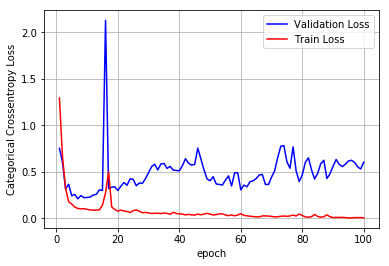

In [128]:
from keras.layers import Conv1D, BatchNormalization, Dropout, MaxPool1D, Flatten
import keras


n_epocs= 100
def modelgen(filters):
  cnnmodel= Sequential()


  cnnmodel.add((Conv1D(filters=filters, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal')))
  cnnmodel.add((Conv1D(filters=filters, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal')))
  cnnmodel.add((MaxPool1D(pool_size=7))) #3

  cnnmodel.add((Conv1D(filters=filters, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal')))
  cnnmodel.add((Conv1D(filters=filters, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal')))
  cnnmodel.add((MaxPool1D(pool_size=5))) #3

  cnnmodel.add(Conv1D(filters=filters*2, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(Conv1D(filters=filters*2, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(MaxPool1D(pool_size=3))



  # cnnmodel.add(Conv1D(filters=filters*2, kernel_size=15, padding='same', activation='relu', kernel_initializer='he_normal'))
  # cnnmodel.add(Conv1D(filters=filters*2, kernel_size=15, padding='same', activation='relu', kernel_initializer='he_normal'))
  # cnnmodel.add(MaxPool1D(pool_size=3))


  cnnmodel.add(LSTM(filters*2, return_sequences=True, activation='tanh', kernel_initializer='he_normal'))
  cnnmodel.add(LSTM(filters*1, return_sequences=True, activation='tanh', kernel_initializer='he_normal'))
  
  cnnmodel.add(Flatten())

  cnnmodel.add(Dense(filters**2, activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(Dropout(0.90))
  
  cnnmodel.add(Dense(filters**2, activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(Dropout(0.90))

  cnnmodel.add(Dense(6, activation='softmax'))
  cnnmodel.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])#RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

  return cnnmodel

m= modelgen(64)

history= m.fit(X_train, Y_train, batch_size=512, validation_data=(X_test, Y_test), epochs=n_epocs)
print(m.summary())


import matplotlib.pyplot as plt
%matplotlib inline

def plt_dynamic(x, vy, ty, colors=['b']):
 fig,ax = plt.subplots(1,1)
 ax.set_xlabel('epoch')
 ax.set_ylabel('Categorical Crossentropy Loss')
 ax.plot(x, vy, 'b', label="Validation Loss")
 ax.plot(x, ty, 'r', label="Train Loss")
 plt.legend()
 plt.grid()
 fig.canvas.draw()

scores = m.evaluate(X_test, Y_test, verbose=0)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print(scores)
x = list(range(1,n_epocs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)


### 4 2C10 1P7 2C10 1P5 2C10 1P3 LSTM LSTM BATCH 512 

Train on 7352 samples, validate on 2947 samples
Epoch 1/100
7352/7352 [==============================] - 31s 4ms/step - loss: 1.2824 - acc: 0.4091 - val_loss: 0.6296 - val_acc: 0.7167
Epoch 2/100
7352/7352 [==============================] - 2s 257us/step - loss: 0.5169 - acc: 0.7677 - val_loss: 0.4638 - val_acc: 0.7876
Epoch 3/100
7352/7352 [==============================] - 2s 250us/step - loss: 0.2030 - acc: 0.9173 - val_loss: 0.2730 - val_acc: 0.9074
Epoch 4/100
7352/7352 [==============================] - 2s 248us/step - loss: 0.1356 - acc: 0.9446 - val_loss: 0.4487 - val_acc: 0.8985
Epoch 5/100
7352/7352 [==============================] - 2s 251us/step - loss: 0.1194 - acc: 0.9495 - val_loss: 0.2329 - val_acc: 0.9199
Epoch 6/100
7352/7352 [==============================] - 2s 249us/step - loss: 0.1043 - acc: 0.9542 - val_loss: 0.2089 - val_acc: 0.9345
Epoch 7/100
7352/7352 [==============================] - 2s 251us/step - loss: 0.0943 - acc: 0.9597 - val_loss: 0.3345 - val_acc: 0

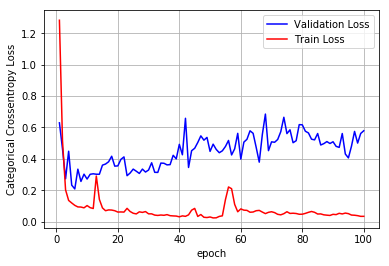

In [129]:
from keras.layers import Conv1D, BatchNormalization, Dropout, MaxPool1D, Flatten
import keras


n_epocs= 100
def modelgen(filters):
  cnnmodel= Sequential()


  cnnmodel.add((Conv1D(filters=filters, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal')))
  cnnmodel.add((Conv1D(filters=filters, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal')))
  cnnmodel.add((MaxPool1D(pool_size=7))) #3

  cnnmodel.add((Conv1D(filters=filters*2, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal')))
  cnnmodel.add((Conv1D(filters=filters*2, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal')))
  cnnmodel.add((MaxPool1D(pool_size=5))) #3

  cnnmodel.add(Conv1D(filters=filters*4, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(Conv1D(filters=filters*4, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(MaxPool1D(pool_size=3))



  # cnnmodel.add(Conv1D(filters=filters*2, kernel_size=15, padding='same', activation='relu', kernel_initializer='he_normal'))
  # cnnmodel.add(Conv1D(filters=filters*2, kernel_size=15, padding='same', activation='relu', kernel_initializer='he_normal'))
  # cnnmodel.add(MaxPool1D(pool_size=3))


  cnnmodel.add(LSTM(filters*2, return_sequences=True, activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(LSTM(filters*1, return_sequences=True, activation='relu', kernel_initializer='he_normal'))
  
  cnnmodel.add(Flatten())

  cnnmodel.add(Dense(filters**2, activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(Dropout(0.90))
  
  cnnmodel.add(Dense(filters**2, activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(Dropout(0.90))

  cnnmodel.add(Dense(6, activation='softmax'))
  cnnmodel.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])#RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

  return cnnmodel

m= modelgen(64)

history= m.fit(X_train, Y_train, batch_size=512, validation_data=(X_test, Y_test), epochs=n_epocs)
print(m.summary())


import matplotlib.pyplot as plt
%matplotlib inline

def plt_dynamic(x, vy, ty, colors=['b']):
 fig,ax = plt.subplots(1,1)
 ax.set_xlabel('epoch')
 ax.set_ylabel('Categorical Crossentropy Loss')
 ax.plot(x, vy, 'b', label="Validation Loss")
 ax.plot(x, ty, 'r', label="Train Loss")
 plt.legend()
 plt.grid()
 fig.canvas.draw()

scores = m.evaluate(X_test, Y_test, verbose=0)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print(scores)
x = list(range(1,n_epocs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)


### 4 2C10 1P7 2C10 1P5 2C10 1P3 LSTM LSTM BATCH 512 

In [0]:
from keras.layers import Conv1D, BatchNormalization, Dropout, MaxPool1D, Flatten
import keras


n_epocs= 100
def modelgen(filters):
  cnnmodel= Sequential()


  cnnmodel.add((Conv1D(filters=filters, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal')))
  cnnmodel.add((Conv1D(filters=filters, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal')))
  cnnmodel.add((MaxPool1D(pool_size=7))) #3

  cnnmodel.add((Conv1D(filters=filters, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal')))
  cnnmodel.add((Conv1D(filters=filters, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal')))
  cnnmodel.add((MaxPool1D(pool_size=5))) #3

  cnnmodel.add(Conv1D(filters=filters*2, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(Conv1D(filters=filters*2, kernel_size=10, padding='same', activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(MaxPool1D(pool_size=3))



  # cnnmodel.add(Conv1D(filters=filters*2, kernel_size=15, padding='same', activation='relu', kernel_initializer='he_normal'))
  # cnnmodel.add(Conv1D(filters=filters*2, kernel_size=15, padding='same', activation='relu', kernel_initializer='he_normal'))
  # cnnmodel.add(MaxPool1D(pool_size=3))


  cnnmodel.add(LSTM(filters*2, return_sequences=True, activation='tanh', kernel_initializer='he_normal'))
  cnnmodel.add(LSTM(filters*1, return_sequences=True, activation='tanh', kernel_initializer='he_normal'))
  
  cnnmodel.add(Flatten())

  cnnmodel.add(Dense(filters**2, activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(Dropout(0.90))
  
  cnnmodel.add(Dense(filters**2, activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(Dropout(0.90))

  cnnmodel.add(Dense(6, activation='softmax'))
  cnnmodel.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])#RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

  return cnnmodel

m= modelgen(64)

history= m.fit(X_train, Y_train, batch_size=512, validation_data=(X_test, Y_test), epochs=n_epocs)
print(m.summary())


import matplotlib.pyplot as plt
%matplotlib inline

def plt_dynamic(x, vy, ty, colors=['b']):
 fig,ax = plt.subplots(1,1)
 ax.set_xlabel('epoch')
 ax.set_ylabel('Categorical Crossentropy Loss')
 ax.plot(x, vy, 'b', label="Validation Loss")
 ax.plot(x, ty, 'r', label="Train Loss")
 plt.legend()
 plt.grid()
 fig.canvas.draw()

scores = m.evaluate(X_test, Y_test, verbose=0)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print(scores)
x = list(range(1,n_epocs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)


Train on 7352 samples, validate on 2947 samples
Epoch 1/100
7352/7352 [==============================] - 32s 4ms/step - loss: 1.3534 - acc: 0.4127 - val_loss: 0.6479 - val_acc: 0.7360
Epoch 2/100
7352/7352 [==============================] - 2s 240us/step - loss: 0.6805 - acc: 0.7112 - val_loss: 0.5753 - val_acc: 0.7296
Epoch 3/100
7352/7352 [==============================] - 2s 228us/step - loss: 0.3586 - acc: 0.8554 - val_loss: 0.5197 - val_acc: 0.8086
Epoch 4/100
7352/7352 [==============================] - 2s 229us/step - loss: 0.1966 - acc: 0.9252 - val_loss: 0.4315 - val_acc: 0.8765
Epoch 5/100
7352/7352 [==============================] - 2s 230us/step - loss: 0.1331 - acc: 0.9448 - val_loss: 0.3958 - val_acc: 0.8941
Epoch 6/100
7352/7352 [==============================] - 2s 231us/step - loss: 0.1137 - acc: 0.9520 - val_loss: 0.4281 - val_acc: 0.9023
Epoch 7/100
1536/7352 [=====>........................] - ETA: 1s - loss: 0.0894 - acc: 0.9590

### Adding a LSTM layer on top of CNN

In [123]:
# Taking reference from vgg19 and implementin a CNN model

from keras.layers import Conv1D, BatchNormalization, Dropout, MaxPool1D, Flatten
import keras

n_epocs= 60
def modelgen(filters):
  cnnmodel= Sequential()
  #Block 1
  cnnmodel.add(Conv1D(filters=filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal', input_shape=(timesteps, input_dim)))
  cnnmodel.add(Conv1D(filters=filters, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(MaxPool1D(pool_size=2))
  
  #Block 2
  cnnmodel.add(Conv1D(filters=filters*2, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(Conv1D(filters=filters*2, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(MaxPool1D(pool_size=2))
  
  #Block 3
  cnnmodel.add(Conv1D(filters=filters*4, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(Conv1D(filters=filters*4, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(Conv1D(filters=filters*4, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(Conv1D(filters=filters*4, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(MaxPool1D(pool_size=2))
  
  #Block 4
  cnnmodel.add(Conv1D(filters=filters*8, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(Conv1D(filters=filters*8, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(Conv1D(filters=filters*8, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(Conv1D(filters=filters*8, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(MaxPool1D(pool_size=2))

  #Block 5
  cnnmodel.add(Conv1D(filters=filters*8, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(Conv1D(filters=filters*8, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(Conv1D(filters=filters*8, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(Conv1D(filters=filters*8, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(MaxPool1D(pool_size=2))

  #Block 6
  cnnmodel.add(LSTM(filters*8, return_sequences=True, activation='relu'))
  cnnmodel.add(LSTM(filters*4, return_sequences=True, activation='relu'))
  cnnmodel.add(LSTM(filters*2, return_sequences=True, activation='relu'))
  cnnmodel.add(LSTM(filters, return_sequences=True, activation='relu'))

  cnnmodel.add(Flatten())
  cnnmodel.add(Dense(filters**2, activation='relu'))
  cnnmodel.add(Dropout(0.90))
  cnnmodel.add(Dense(filters**2, activation='relu'))
  cnnmodel.add(Dropout(0.90))
  cnnmodel.add(Dense(6, activation='softmax'))

  cnnmodel.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])#RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

  return cnnmodel


m= modelgen(16)

history= m.fit(X_train,
          Y_train,
          batch_size=32,
          validation_data=(X_test, Y_test),
          epochs=n_epocs)
m.summary()


import matplotlib.pyplot as plt
%matplotlib inline

def plt_dynamic(x, vy, ty, colors=['b']):
 fig,ax = plt.subplots(1,1)
 ax.set_xlabel('epoch')
 ax.set_ylabel('Categorical Crossentropy Loss')
 ax.plot(x, vy, 'b', label="Validation Loss")
 ax.plot(x, ty, 'r', label="Train Loss")
 plt.legend()
 plt.grid()
 fig.canvas.draw()

scores = m.evaluate(X_test, Y_test, verbose=0)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print(scores)
x = list(range(1,n_epocs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)





Train on 7352 samples, validate on 2947 samples
Epoch 1/60


KeyboardInterrupt: ignored

### Hyperparameter tuning

In [0]:
# Taking reference from vgg19 and implementin a CNN model

from keras.layers import Conv1D, BatchNormalization, Dropout, MaxPool1D, Flatten
import keras

n_epocs= 30
def modelgen(filters, drop):
  cnnmodel= Sequential()
  #Block 1
  cnnmodel.add(Conv1D(filters=filters, kernel_size=3, padding='same', activation='relu',  kernel_initializer='he_normal', input_shape=(timesteps, input_dim)))
  cnnmodel.add(Conv1D(filters=filters, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(MaxPool1D(pool_size=2))
  
  #Block 2
  cnnmodel.add(Conv1D(filters=filters*2, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(Conv1D(filters=filters*2, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(MaxPool1D(pool_size=2))
  
  #Block 3
  cnnmodel.add(Conv1D(filters=filters*4, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(Conv1D(filters=filters*4, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(Conv1D(filters=filters*4, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(Conv1D(filters=filters*4, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(MaxPool1D(pool_size=2))
  
  #Block 4
  cnnmodel.add(Conv1D(filters=filters*8, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(Conv1D(filters=filters*8, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(Conv1D(filters=filters*8, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(Conv1D(filters=filters*8, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(MaxPool1D(pool_size=2))

  #Block 5
  cnnmodel.add(Conv1D(filters=filters*8, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(Conv1D(filters=filters*8, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(Conv1D(filters=filters*8, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(Conv1D(filters=filters*8, kernel_size=3, padding='same', activation='relu'))
  cnnmodel.add(MaxPool1D(pool_size=2))

  #Block 6


  cnnmodel.add(Flatten())
  cnnmodel.add(Dense(filters*64, activation='relu'))
  cnnmodel.add(Dropout(drop))
  cnnmodel.add(Dense(filters*64, activation='relu'))
  cnnmodel.add(Dropout(drop))
  cnnmodel.add(Dense(6, activation='softmax'))

  cnnmodel.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])#RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

  return cnnmodel


# Hyper parameter tuning on kernel size
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, ShuffleSplit
model = KerasClassifier(build_fn=modelgen, epochs=30, verbose=0)
param_grid = dict(filters= [32], drop= [0.7, 0.8, 0.9])
grid = GridSearchCV( estimator= model, param_grid= param_grid, cv= 2, return_train_score= True, verbose= 1)
grid_result= grid.fit(X_train, Y_train)


Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 16.9min finished


In [0]:
print( "Best: %f using %s" % ( grid_result.best_score_, grid_result.best_params_))
print( "Best estimator: " , grid_result.best_estimator_)
means_test = grid_result.cv_results_[ 'mean_test_score' ]
means_train = grid_result.cv_results_[ 'mean_train_score' ]
stds_test = grid_result.cv_results_[ 'std_test_score' ]
stds_train = grid_result.cv_results_[ 'std_train_score' ]
params = grid_result.cv_results_[ 'params' ]
for mean, mean_train, stdev, param in zip( means_test, means_train, stds_test, params):
  print( " %f %f ( %f) with: %r" % ( mean, mean_train, stdev, param))

Best: 0.913357 using {'drop': 0.9, 'filters': 32}
Best estimator:  <keras.wrappers.scikit_learn.KerasClassifier object at 0x7efec7b25fd0>
 0.901251 0.974157 ( 0.016050) with: {'drop': 0.7, 'filters': 32}
 0.911725 0.982182 ( 0.023803) with: {'drop': 0.8, 'filters': 32}
 0.913357 0.979597 ( 0.019995) with: {'drop': 0.9, 'filters': 32}


In [0]:
# kernel 3 (.75 with 18)
# filters 32

### 64:256: 100 **epcs**

In [35]:
# Inspired from vgg19 and implementin a CNN model

from keras.layers import Conv1D, BatchNormalization, Dropout, AvgPool1D, Flatten
import keras

n_epocs= 30
def modelgen(filters):
  cnnmodel= Sequential()

  #Block 1
  cnnmodel.add(Conv1D(filters=filters, kernel_size=3, padding='same', activation='relu',  kernel_initializer='he_normal'))
  cnnmodel.add(Conv1D(filters=filters, kernel_size=3, padding='same', activation='relu',  kernel_initializer='he_normal'))
  cnnmodel.add(AvgPool1D(pool_size=2))
  
  #Block 2
  cnnmodel.add(Conv1D(filters=filters*2, kernel_size=3, padding='same', activation='relu',  kernel_initializer='he_normal'))
  cnnmodel.add(Conv1D(filters=filters*2, kernel_size=3, padding='same', activation='relu',  kernel_initializer='he_normal'))
  cnnmodel.add(AvgPool1D(pool_size=2))
  
  #Block 3
  cnnmodel.add(Conv1D(filters=filters*4, kernel_size=3, padding='same', activation='relu',  kernel_initializer='he_normal'))
  cnnmodel.add(Conv1D(filters=filters*4, kernel_size=3, padding='same', activation='relu',  kernel_initializer='he_normal'))
  cnnmodel.add(Conv1D(filters=filters*4, kernel_size=3, padding='same', activation='relu',  kernel_initializer='he_normal'))
  cnnmodel.add(Conv1D(filters=filters*4, kernel_size=3, padding='same', activation='relu',  kernel_initializer='he_normal'))
  cnnmodel.add(AvgPool1D(pool_size=2))
  
  #Block 4
  cnnmodel.add(Conv1D(filters=filters*8, kernel_size=3, padding='same', activation='relu',  kernel_initializer='he_normal'))
  cnnmodel.add(Conv1D(filters=filters*8, kernel_size=3, padding='same', activation='relu',  kernel_initializer='he_normal'))
  cnnmodel.add(Conv1D(filters=filters*8, kernel_size=3, padding='same', activation='relu',  kernel_initializer='he_normal'))
  cnnmodel.add(Conv1D(filters=filters*8, kernel_size=3, padding='same', activation='relu',  kernel_initializer='he_normal'))
  cnnmodel.add(AvgPool1D(pool_size=2))

  #Block 5
  cnnmodel.add(Conv1D(filters=filters*8, kernel_size=3, padding='same', activation='relu',  kernel_initializer='he_normal'))
  cnnmodel.add(Conv1D(filters=filters*8, kernel_size=3, padding='same', activation='relu',  kernel_initializer='he_normal'))
  cnnmodel.add(Conv1D(filters=filters*8, kernel_size=3, padding='same', activation='relu',  kernel_initializer='he_normal'))
  cnnmodel.add(Conv1D(filters=filters*8, kernel_size=3, padding='same', activation='relu',  kernel_initializer='he_normal'))
  cnnmodel.add(AvgPool1D(pool_size=2))

  #Block 6



  cnnmodel.add(Flatten())
  cnnmodel.add(Dense(filters*64, activation='relu',  kernel_initializer='he_normal'))
  cnnmodel.add(Dropout(0.90))
  cnnmodel.add(Dense(filters*64, activation='relu',  kernel_initializer='he_normal'))
  cnnmodel.add(Dropout(0.90))
  cnnmodel.add(Dense(6, activation='softmax'))

  cnnmodel.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])#RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

  return cnnmodel


m= modelgen(128) #64 before

history= m.fit(X_train,
          Y_train,
          batch_size=256,
          validation_data=(X_test, Y_test),
          epochs=n_epocs)
m.summary()


import matplotlib.pyplot as plt
%matplotlib inline

def plt_dynamic(x, vy, ty, colors=['b']):
 fig,ax = plt.subplots(1,1)
 ax.set_xlabel('epoch')
 ax.set_ylabel('Categorical Crossentropy Loss')
 ax.plot(x, vy, 'b', label="Validation Loss")
 ax.plot(x, ty, 'r', label="Train Loss")
 plt.legend()
 plt.grid()
 fig.canvas.draw()

scores = m.evaluate(X_test, Y_test, verbose=0)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print(scores)
x = list(range(1,n_epocs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, 1)


ValueError: ignored

Without LSTM, batch size: 256, 1st layer 64, lr: 0.0001

Test loss: 0.5077617218487018
Test accuracy: 0.9212758737699356
[0.5077617218487018, 0.9212758737699356]